In [135]:
import requests
from bs4 import BeautifulSoup
import csv
import os
from calendar import monthrange

In [136]:
# create the data folder
save_path = './webdata'
if not os.path.exists(save_path):
    os.mkdir(save_path)

for year in range(2014, 2019):
    for month in range(1, 13):
        filename = './webdata/weather' + str(year) + '_' + str(month).zfill(3) + '.htm'
        url = 'https://www.isws.illinois.edu/statecli/urbana/urbana-monthly-' + str(year) + '_files/sheet' + str(month).zfill(3) + '.htm'
        # don't panic if you can't open the downloaded htm file in your browser since the original frame page is missing. Try opening with text editing programs to see if you download the data correctly.
        if os.path.isfile(filename):
            pass
        else:
            print('Fetching the data from %s \n' % url)
            res = requests.get(url)
            c = res.text
            with open(filename,'w') as f:
                f.write(c)

In [137]:
outfile =  open('weather.csv','w', newline='')
f = csv.writer(outfile)  
# write the headers first  
f.writerow(['Year', 'Month', 'Day', 'High Temperature','Low Temperature', 'Precipitation', 'Snowfall', 'Comments'])
for year in range(2014, 2019):
    for month in range(1, 13):
        # use the 'monthrange' function from the calendar module to calculate the number of days in a month
        day_of_month = monthrange(year,month)[1]
        filename = './webdata/weather' + str(year) + '_' + str(month).zfill(3) + '.htm'
        webfile = open(filename, 'r')
        c = webfile.read()
        webfile.close()
        
        soup = BeautifulSoup(c, 'html.parser')
        # find all the objects beginning with 'tr'
        trs = soup.find('table').find_all('tr')
        
        if year == 2014 and month < 10 :
            # locate the rows that contain the target information
            trs_data = trs[6:6+day_of_month]
        
        # the format of the records changes over time. So you need to find the correct starting row yourself.
        elif (year == 2014 and month >= 10 ) or year == 2015:
            trs_data = trs[7:7+day_of_month]   
        elif year == 2016 and month == 12:
            trs_data = trs[13:13+day_of_month]
        else:
            trs_data = trs[9:(9+day_of_month)]
 
        for row in trs_data:
            # try to locate the columns that we are interested in 
            tds = row.find_all('td')
            # the first two columns should be year and month
            record = [year, month]
            if year == 2014 and month <= 10:
                for col_ind in [0,1,3,8,9,11]:
                    record.append(tds[col_ind].text)
            else:
            #the column number also varies over time. Find the correct column numbers.
                for col_ind in [0,1,3,9,10,15]:
                    record.append(tds[col_ind].text)
            f.writerow(record) 
outfile.close()



In [138]:
import pandas as pd
from sqlalchemy import create_engine
import datetime as dt

In [139]:
DT_panda = pd.read_csv('weather.csv',header=0)

In [140]:
DT_panda

,Year,Month,Day,High Temperature,Low Temperature,Precipitation,Snowfall,Comments
0,2014,1,1,32,18,0,0,NaN
1,2014,1,2,19,5,0.21,2,snow
2,2014,1,3,18,-6,T,0.3,light snow
3,2014,1,4,37,18,0,0,NaN
4,2014,1,5,32,-3,0.06,0.4,NaN
5,2014,1,6,-3,-14,0.21,5.9,"snow, blowing snow, Record low temp (surpassed..."
6,2014,1,7,9,-13,0,0,blowing snow
7,2014,1,8,21,3,0,0,NaN
8,2014,1,9,30,14,T,0.3,light snow
9,2014,1,10,40,30,0.04,0.2,light snow


In [141]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

print(mem_usage(DT_panda))
print(DT_panda.shape)

0.41 MB
(1826, 8)


In [142]:
#question 2
Jan=DT_panda.loc[DT_panda['Month'] == 1]
Y2014=Jan.loc[Jan['Year']==2014]
Y2015=Jan.loc[Jan['Year']==2015]
Y2016=Jan.loc[Jan['Year']==2016]
Y2017=Jan.loc[Jan['Year']==2017]
Y2018=Jan.loc[Jan['Year']==2018]

In [143]:
#2.a get average of high and low in different years
H2018=Y2018["High Temperature"].mean()
H2017=Y2017["High Temperature"].mean()
H2016=Y2016["High Temperature"].mean()
H2015=Y2015["High Temperature"].mean()
H2014=Y2014["High Temperature"].mean()

L2018=Y2018["Low Temperature"].mean()
L2017=Y2017["Low Temperature"].mean()
L2016=Y2016["Low Temperature"].mean()
L2015=Y2015["Low Temperature"].mean()
L2014=Y2014["Low Temperature"].mean()

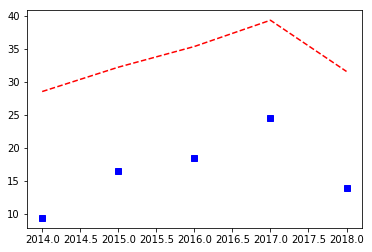

In [144]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
x=np.arange(2014,2019,1)
y1=[H2014,H2015,H2016,H2017,H2018]
y2=[L2014,L2015,L2016,L2017,L2018]
plt.plot(x, y1, 'r--', x, y2, 'bs')#Red one is High Temperature, Blue one is Low Temperature
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


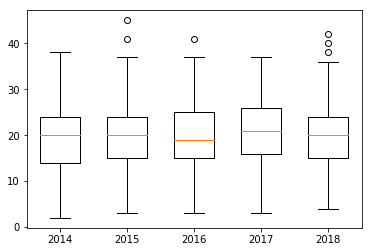

In [145]:
#2.b
DT_panda['daily difference'] = DT_panda["High Temperature"].sub(DT_panda['Low Temperature'], axis=0)
D2014=DT_panda.loc[DT_panda["Year"]==2014]
D2015=DT_panda.loc[DT_panda["Year"]==2015]
D2016=DT_panda.loc[DT_panda["Year"]==2016]
D2017=DT_panda.loc[DT_panda["Year"]==2017]
D2018=DT_panda.loc[DT_panda["Year"]==2018]

plt.boxplot([D2014["daily difference"],D2015["daily difference"],D2016["daily difference"],\
             D2017["daily difference"],D2018["daily difference"]],positions=[2014,2015,2016,2017,2018],\
            widths=0.6)

plt.show()


In [195]:
#3：study the correlation between these four following factors to see wether they may predict something


DT_panda["Precipitation"].loc[DT_panda["Precipitation"] == "T"] = 0.00
DT_panda["Snowfall"].loc[DT_panda["Snowfall"] == "T"] = 0.00



/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


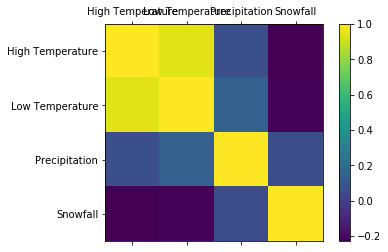

In [196]:

corr_data=DT_panda[[ 'High Temperature','Low Temperature','Precipitation', 'Snowfall']]
corr_data = corr_data.apply(pd.to_numeric)

correlation=corr_data.corr()
names=['High Temperature','Low Temperature', 'Precipitation', 'Snowfall']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation)
fig.colorbar(cax)
ticks = np.arange(0,4,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()